In [25]:
import dataset_utils
from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
import numpy as np
import time
data_path = "./fvec_datasets/Cancer.fvec"
Index_path = "./data/index_Cancer_R64_L100_A1.2"
adj_dict = dataset_utils.Index_read(Index_path)

print("--")
adj_dict = dataset_utils.Index_read(Index_path)
sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,input_file = data_path, aproximate_almost_zero=False)
MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
l = MST.nonzero()
print(len(l[0]))
print(len(l[1]))
print(MST.getnnz())
print(len(MST.data))

sparse_adj_matrix
print(sparse_adj_matrix.getnnz())







--
459
459
459
459
9782


In [39]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
X = csr_matrix([[0, 3, 0, 2],
                [3, 0, 3, 5],
                [0, 3, 0, 2],
                [2, 5, 2, 0]])
X[0,2] = 0
X[2,0] = 0
Tcsr = minimum_spanning_tree(X)
print(Tcsr)
print(f'non-zero entries: {Tcsr.nnz}')

  (0, 1)	3.0
  (0, 3)	2.0
non-zero entries: 2


In [1]:
def MST_time_compare(data_path, Index_path):
    import dataset_utils
    from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
    from scipy.spatial.distance import pdist, squareform
    from scipy.sparse.csgraph import minimum_spanning_tree
    from scipy.sparse import csr_matrix
    import numpy as np
    import time

    

    print("--")
    start = time.time()
    adj_dict = dataset_utils.Index_read(Index_path)
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,data_path, aproximate_almost_zero=False)
    end = time.time()
    sparse_matrix_building_time = end - start
    

    start = time.time()
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    end = time.time()
    MST_from_sparse_time = end - start


    # MST_from_sparse_weight = MST.data.sum()


    


    start = time.time()
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,data_path, aproximate_almost_zero=True)
    end = time.time()
    
    sparse_matrix_noise_building_time = end - start
    # ngb = adj_dict[32][0]
    # print(f"Distance between 32 and {ngb} from adj_matrix:",sparse_adj_matrix[32,ngb])
    # input = dataset_utils.fvecs_read("fvec_datasets/sift_learn.fvecs")
    # print(f"Distance between 32 and {ngb} from input:",np.linalg.norm(input[32,:] - input[ngb,:]))

    start = time.time()
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    end = time.time()

    MST_from_sparse_noise_time = end - start


    # MST_from_sparse_noise_weight = MST.data.sum()


    #Dense approach
    try:
        start_block = time.time()
        start = time.time()
        input = dataset_utils.fvecs_read(data_path)
        print( "time to read", time.time() - start)
        dense_adj_matrix =  squareform(pdist(input))
        end = time.time()
        dense_matrix_building_time = end - start
        print(dense_matrix_building_time)
        start = time.time()
        mst = minimum_spanning_tree(dense_adj_matrix)
        end = time.time()
        

        MST_from_dense_time = end - start
        print(MST_from_dense_time)
        # MST_from_dense_weight = mst.data.sum()
                
    except Exception as e:

        print(e)
        end_block = time.time()
        print(end_block - start_block)


        dense_matrix_building_time = np.inf

        MST_from_dense_time = np.inf

        MST_from_dense_weight = np.inf

    return [sparse_matrix_building_time, MST_from_sparse_time, sparse_matrix_noise_building_time, MST_from_sparse_noise_time, dense_matrix_building_time,  MST_from_dense_time]
        











In [2]:
def compare_datasets_mst():
    import os 
    import pandas as pd
    import time
    name_of_dir = "fvec_datasets"

    list_of_files = filter( lambda x: os.path.isfile 
                       (os.path.join(name_of_dir, x)), 
                        os.listdir(name_of_dir) ) 
    list_of_files = sorted( list_of_files, 
                        key =  lambda x: os.stat 
                       (os.path.join(name_of_dir, x)).st_size)

    results = [] 
    
    for dataset in list_of_files:
        data_path = os.path.join(name_of_dir,dataset)
        name = dataset.split(".")[0]
        index_path = "data/" + f'index_{name}_R64_L100_A1.2'
        
        result = MST_time_compare(data_path, index_path)
        
        print(name, result)
        results.append(result)

    col_names = ["sparse_matrix_building_time", "MST_from_sparse_time", "sparse_matrix_noise_building_time", "MST_from_sparse_noise_time", "dense_matrix_building_time",  "MST_from_dense_time"]

    df = pd.DataFrame(results, columns = col_names)
    return df
    

    
    

df = compare_datasets_mst()

--
time to read 0.0
0.0
0.0
iris [0.0, 0.0, 0.015805482864379883, 0.0, 0.0, 0.0]
--
time to read 0.0
0.0
0.0
seeds [0.017101764678955078, 0.0, 0.015896081924438477, 0.0, 0.0, 0.0]
--
time to read 0.0
0.015091180801391602
0.05748748779296875
Cancer [0.06663846969604492, 0.0, 0.06781482696533203, 0.0, 0.015091180801391602, 0.05748748779296875]
--
time to read 0.0
0.06289243698120117
0.8172929286956787
mfeat [0.2624680995941162, 0.0, 0.3740873336791992, 0.0, 0.06289243698120117, 0.8172929286956787]
--
time to read 0.06249594688415527
Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64
711.1883335113525
sift_learn [48.73481059074402, 1.444870948791504, 59.85625648498535, 1.6549639701843262, inf, inf]
--


KeyboardInterrupt: 

In [14]:
df

,sparse_matrix_building_time,MST_from_sparse_time,MST_from_sparse_weight,sparse_matrix_noise_building_time,MST_from_sparse_noise_time,MST_from_sparse_noise_weight,dense_matrix_building_time,MST_from_dense_time,MST_from_dense_weight
0,0.019058,0.000000,4.398371e+01,0.014961,0.000000,4.337274e+01,0.001994,0.010973,4.398371e+01
1,0.016951,0.000998,1.015096e+02,0.020951,0.000000,1.015097e+02,0.000994,0.005984,1.015096e+02
2,0.078349,0.000998,1.653567e+03,0.088286,0.000997,1.399327e+03,0.005993,0.070669,1.648194e+03
3,0.297659,0.004993,2.165715e+04,0.412115,0.005964,2.159259e+04,0.077373,0.845494,2.165625e+04
4,48.952452,1.678169,2.102798e+07,66.747716,1.739800,2.097714e+07,inf,inf,inf
5,32.503515,1.027806,6.492097e+07,37.309481,0.803302,6.492097e+07,inf,inf,inf


In [ ]:
def MST_time_compare2(data_path, Index_path):
    import dataset_utils
    from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
    from scipy.spatial.distance import pdist, squareform
    from scipy.sparse.csgraph import minimum_spanning_tree
    from scipy.sparse import csr_matrix
    import numpy as np
    import time

    adj_dict = dataset_utils.Index_read(Index_path)

    print("--")
    start = time.time()
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,data_path, aproximate_almost_zero=False)
    end = time.time()
    sparse_matrix_building_time = end - start
    

    start = time.time()
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    end = time.time()
    MST_from_sparse_time = end - start




    #Dense approach
    
    
    try:
        start = time.time()
        input = dataset_utils.fvecs_read(data_path)
        dense_adj_matrix =  squareform(pdist(input))
        end = time.time()
        dense_matrix_building_time = end - start
        start = time.time()
        mst = minimum_spanning_tree(dense_adj_matrix)
        end = time.time()

        MST_from_dense_time = end - start
                
    except:

        dense_matrix_building_time = np.inf

        MST_from_dense_time = np.inf

        # MST_from_dense_weight = np.inf

    return [sparse_matrix_building_time, MST_from_sparse_time,  dense_matrix_building_time,  MST_from_dense_time]
        











In [3]:
def compare_datasets_mst2():
    import os 
    import pandas as pd
    import time
    name_of_dir = "fvec_datasets"

    list_of_files = filter( lambda x: os.path.isfile 
                       (os.path.join(name_of_dir, x)), 
                        os.listdir(name_of_dir) ) 
    list_of_files = sorted( list_of_files, 
                        key =  lambda x: os.stat 
                       (os.path.join(name_of_dir, x)).st_size)

    results = [] 
    
    for dataset in list_of_files:
        data_path = os.path.join(name_of_dir,dataset)
        name = dataset.split(".")[0]
        index_path = "data/" + f'index_{name}_R64_L100_A1.2'
        
        result = MST_time_compare2(data_path, index_path)
        
        print(name, result)
        results.append(result)

    col_names = ["sparse_matrix_building_time", "MST_from_sparse_time",  "dense_matrix_building_time",  "MST_from_dense_time"]

    df = pd.DataFrame(results, columns = col_names)
    return df
    

compare_datasets_mst2()

--
iris [0.009673118591308594, 0.0, 0.0009970664978027344, 0.003992319107055664]
--
seeds [0.01744675636291504, 0.0009999275207519531, 0.0, 0.008656501770019531]
--
Cancer [0.05540728569030762, 0.000997781753540039, 0.00299072265625, 0.06244778633117676]
--
mfeat [0.2688286304473877, 0.0, 0.07733011245727539, 0.7709779739379883]
--


In [2]:
def MST_time_compare_mlpack(data_path, Index_path):
    import dataset_utils
    from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
    from scipy.spatial.distance import pdist, squareform
    from scipy.sparse.csgraph import minimum_spanning_tree
    from scipy.sparse import csr_matrix
    import numpy as np
    import time
    import mlpack

    

    print("--")
    start = time.time()
    adj_dict = dataset_utils.Index_read(Index_path)
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,data_path, aproximate_almost_zero=False)
    end = time.time()
    sparse_matrix_building_time = end - start
    

    start = time.time()
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    end = time.time()
    MST_from_sparse_time = end - start


    # MST_from_sparse_weight = MST.data.sum()


    


    start = time.time()
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,data_path, aproximate_almost_zero=True)
    end = time.time()
    
    sparse_matrix_noise_building_time = end - start
    # ngb = adj_dict[32][0]
    # print(f"Distance between 32 and {ngb} from adj_matrix:",sparse_adj_matrix[32,ngb])
    # input = dataset_utils.fvecs_read("fvec_datasets/sift_learn.fvecs")
    # print(f"Distance between 32 and {ngb} from input:",np.linalg.norm(input[32,:] - input[ngb,:]))

    start = time.time()
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    end = time.time()

    MST_from_sparse_noise_time = end - start


    # MST_from_sparse_noise_weight = MST.data.sum()


    #Dense approach
    try:
        start_block = time.time()
        start = time.time()
        input = dataset_utils.fvecs_read(data_path)
        print( "time to read", time.time() - start)
        d = mlpack.emst(input_ = input)
        end = time.time()
        MST_mlpack_time = end - start

        
                
    except Exception as e:

        print(e)
        end_block = time.time()
        print(end_block - start_block)
        MST_mlpack_time = np.inf


    return [sparse_matrix_building_time, MST_from_sparse_time, sparse_matrix_noise_building_time, MST_from_sparse_noise_time, MST_mlpack_time]
        











In [3]:
def compare_datasets_mst_mlpack():
    import os 
    import pandas as pd
    import time
    name_of_dir = "fvec_datasets"

    list_of_files = filter( lambda x: os.path.isfile 
                       (os.path.join(name_of_dir, x)), 
                        os.listdir(name_of_dir) ) 
    list_of_files = sorted( list_of_files, 
                        key =  lambda x: os.stat 
                       (os.path.join(name_of_dir, x)).st_size)

    results = [] 
    
    for dataset in list_of_files:
        data_path = os.path.join(name_of_dir,dataset)
        name = dataset.split(".")[0]
        index_path = "data/" + f'index_{name}_R64_L100_A1.2'
        
        result = MST_time_compare_mlpack(data_path, index_path)
        
        print(name, result)
        results.append(result)

    col_names = ["sparse_matrix_building_time", "MST_from_sparse_time", "sparse_matrix_noise_building_time", "MST_from_sparse_noise_time", "MST_mlpack_time"]

    df = pd.DataFrame(results, columns = col_names)
    return df
    

df = compare_datasets_mst_mlpack()

df.to_csv("ml_pack_comparison.csv")

--
time to read 0.0
iris [0.03124403953552246, 0.009010791778564453, 0.024194955825805664, 0.0010039806365966797, 0.0025272369384765625]
--
time to read 0.0
seeds [0.031153202056884766, 0.0, 0.041251182556152344, 0.0, 0.00601959228515625]
--
time to read 0.0
Cancer [0.1687014102935791, 0.001992464065551758, 0.2008817195892334, 0.015621185302734375, 0.019993066787719727]
--
time to read 0.0
mfeat [0.6668143272399902, 0.02113509178161621, 0.7903754711151123, 0.004837751388549805, 0.5595531463623047]
--
time to read 0.06496334075927734
sift_learn [40.981314182281494, 0.8827199935913086, 76.96798610687256, 1.766503095626831, 5163.291917800903]
--


In [1]:
import dataset_utils
from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
import numpy as np
import time
import mlpack

data_path = "./fvec_datasets/mnist.fvec"
Index_path = "./data/index_mnist_R64_L100_A1.2"

print("--")
start = time.time()
adj_dict = dataset_utils.Index_read(Index_path)
sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,data_path, aproximate_almost_zero=False)
end = time.time()
sparse_matrix_building_time = end - start


start = time.time()
MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
end = time.time()
MST_from_sparse_time = end - start

print("sparse matrix building time: ",sparse_matrix_building_time)
print("MST building time: ",MST_from_sparse_time)

--
sparse matrix building time:  38.511393547058105
MST building time:  0.9137058258056641


In [16]:
import dataset_utils
from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
import numpy as np
import time


data_path = "./fvec_datasets/Cancer.fvec"
start = time.time()
input = dataset_utils.fvecs_read(data_path)
print( "time to read", time.time() - start)
d = mlpack.emst(input_ = input)
end = time.time()
MST_mlpack_time = end - start
print(d)
print(type(d['output']))
output1 = d['output']



time to read 0.002507448196411133
{'output': array([[448.        , 496.        ,   0.        ],
       [496.        , 617.        ,   0.        ],
       [393.        , 496.        ,   0.        ],
       ...,
       [ 85.        ,  98.        ,   7.14142843],
       [ 71.        , 648.        ,   9.05538514],
       [167.        , 506.        ,   9.16515139]])}
<class 'numpy.ndarray'>
(698, 3)


In [14]:
def MST_test_weights(data_path, Index_path):
    import dataset_utils
    from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
    from scipy.spatial.distance import pdist, squareform
    from scipy.sparse.csgraph import minimum_spanning_tree
    from scipy.sparse import csr_matrix
    import numpy as np
    import time
    import mlpack

    

    print("--")
    
    adj_dict = dataset_utils.Index_read(Index_path)
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,input_file = data_path, aproximate_almost_zero=False)
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    ANN_weight = MST.data.sum()
    

    try:

        input = dataset_utils.fvecs_read(data_path)
        d = mlpack.emst(input_ = input)
        d = d['output']
        mlpack_weight = d[:,2].sum()
        
                
    except Exception as e:
        print(e)
        mlpack_weight = np.inf


    return [ANN_weight, mlpack_weight]
        




In [15]:
def run_all_ANN_tests():
    import os 
    import pandas as pd
    import time
    name_of_dir = "fvec_datasets"

    list_of_files = filter( lambda x: os.path.isfile 
                       (os.path.join(name_of_dir, x)), 
                        os.listdir(name_of_dir) ) 
    list_of_files = sorted( list_of_files, 
                        key =  lambda x: os.stat 
                       (os.path.join(name_of_dir, x)).st_size)

    results = []
    datasets =[]

    for dataset in list_of_files:
        if(dataset in ["mnist.fvec"]):
            continue
        datasets.append(dataset)
        
        data_path = os.path.join(name_of_dir,dataset)
        name = dataset.split(".")[0]
        index_path = "data/" + f'index_{name}_R64_L100_A1.2'
        
        result = MST_test_weights(data_path, index_path)
        
        
        results.append(result)

        col_names = ["Approximate MST weight","mlpack MST weight"]

    df = pd.DataFrame(results, columns = col_names)
    
    
    df.index = datasets
    return df
    

    
    

df =run_all_ANN_tests()


--
--
--
--
--


In [29]:
df["percentual error"] = abs((df["Approximate MST weight"] - df["mlpack MST weight"])/df["mlpack MST weight"])

In [30]:
import pandas as pd
with pd.option_context('display.float_format', '{:0.3f}'.format):
    print(df)
    

                  Approximate MST weight  mlpack MST weight  percentual error
iris.fvec                         43.373             43.373             0.000
seeds.fvec                       101.510            101.510             0.000
Cancer.fvec                     1399.327           1397.929             0.001
mfeat.fvec                     21592.593          21592.593             0.000
sift_learn.fvecs            20977143.285       20963405.537             0.001


In [1]:
def calc_distance(X, Y):
    import gudhi
    import matplotlib.pyplot as plt
    rips_original = gudhi.RipsComplex(points=X)
    st_original = rips_original.create_simplex_tree(max_dimension=1)

    rips_Y = gudhi.RipsComplex(points=Y)
    st_Y = rips_Y.create_simplex_tree(max_dimension=1)
    
    diag_original = st_original.persistence(min_persistence=0)
    diag_proj = st_Y.persistence(min_persistence=0)

    I_original = st_original.persistence_intervals_in_dimension(0)
    I_Y = st_Y.persistence_intervals_in_dimension(0)

    

    # Create image
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    gudhi.plot_persistence_diagram(diag_original, axes=axs[0])
    axs[0].set_title('Persistance - Original Points')

    gudhi.plot_persistence_diagram(diag_proj, axes=axs[1])
    axs[1].set_title('Persistance - Projections')

    
    fig.suptitle('Persistence diagrams and Projection')
    fig.tight_layout()
    plt.show()
    

    return gudhi.bottleneck_distance(I_original, I_Y)

In [21]:
def MST_test_topology(data_path, Index_path):
    import dataset_utils
    from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
    from scipy.spatial.distance import pdist, squareform
    from scipy.sparse.csgraph import minimum_spanning_tree
    from scipy.sparse import csr_matrix
    from scipy.sparse import coo_matrix
    import numpy as np
    import time
    import mlpack
    import gudhi
    import matplotlib.pyplot as plt
    from graph_building_utils import build_graph_mst_scipy, building_graph_mst_mlpack
    

    print("--")
    adj_dict = dataset_utils.Index_read(Index_path)
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,input_file = data_path, aproximate_almost_zero=False)
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    
    MST = MST.tocoo()

    mst_scipy_nx = build_graph_mst_scipy(MST)
    

    

    input = dataset_utils.fvecs_read(data_path)
    print("non zero edges",MST.nnz)

    rows, columns = MST.row, MST.col
    data = MST.data

    print(sorted(data))
    n_edges = len(rows)
    # rows = set(rows)
    # columns = set(columns)
    # idx_points = list(rows.union(columns))
    # mst_points = [0]*len(idx_points)
    # for i in range(len(idx_points)):
    #     idx = idx_points[i]
    #     mst_points[i] = input[i,:]

    sparse_mst_st = gudhi.SimplexTree()
    for i in range(n_edges+1):
        sparse_mst_st.insert([i])
    for i in range(n_edges):
        sparse_mst_st.insert([int(rows[i]),int(columns[i])], filtration = data[i])

    barcodes = sparse_mst_st.persistence(min_persistence=-1)

    I_mst = sparse_mst_st.persistence_intervals_in_dimension(0)

    

    input = dataset_utils.fvecs_read(data_path)
    d = mlpack.emst(input_ = input)
    d = d['output']
    mst_mlpack_nx = building_graph_mst_mlpack(d)
    print(mst_mlpack_nx)
    rows_mlpack = d[:,0]
    columns_mlpack = d[:,1]
    data_mlpack = d[:,2]
    print(data_mlpack)


    sparse_mst_mlpack = gudhi.SimplexTree()
    for i in range(n_edges+1):
        sparse_mst_mlpack.insert([i])
    for i in range(n_edges):
        sparse_mst_mlpack.insert([int(rows_mlpack[i]),int(columns_mlpack[i])], filtration = data_mlpack[i])

    barcodes_mlpack = sparse_mst_mlpack.persistence(min_persistence=-1)

    # Create image
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].set_title('Persistance - Original Points')
    gudhi.plot_persistence_diagram(barcodes,axes = axs[0])

    gudhi.plot_persistence_diagram(barcodes_mlpack, axes = axs[1])

    I_mlpack = sparse_mst_mlpack.persistence_intervals_in_dimension(0)


    axs[1].set_title('Persistance - Projections')

    
    fig.suptitle('Persistence diagrams and Projection')
    fig.tight_layout()
    plt.show()

    dist = gudhi.bottleneck_distance(I_mst, I_mlpack)
    print('bottleneck distance:', dist)
    # print(d)
    # first_elements = d[:,0]
    # second_elements = d[:,1]
    # first_elements = set([int(i) for i in first_elements])
    # second_elements =set([int(i) for i in second_elements])
    # idx_mlpack_points = list(first_elements.union(second_elements))

    # mlpack_mst_points =  [0]*len(idx_mlpack_points)
    # for i in range(len(idx_mlpack_points)):
    #     idx = idx_mlpack_points[i]
    #     mlpack_mst_points[i] = input[i,:]

    # dist = calc_distance(mlpack_mst_points,mst_points)

    # print(len(mlpack_mst_points),len(mst_points))




    return dist
        




--
not coo
COO
non zero edges 698
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

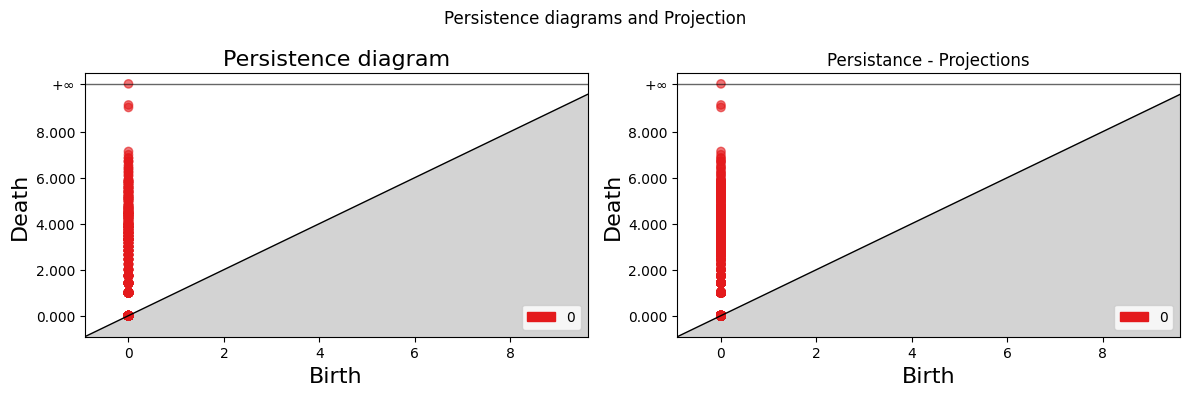

bottleneck distance: 0.16668293510106746
0.16668293510106746


In [22]:
data_path = "./fvec_datasets/Cancer.fvec"
Index_path = "./data/index_Cancer_R64_L100_A1.2"
dist = MST_test_topology(data_path, Index_path)
print(dist)